In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

#Topic Modelling and Sentiment Analysis for Prediction

Read the `Roomba.csv` file. Create a new variable called `rating` which has values `high` and `low`. If the `Stars` value is 4 or 5, then `rating` should be `high`, otherwise `low`. Build models to predict `rating` based on `Review`. Conduct topic modeling (10 topics) and sentiments of `Review` and use these to predict  `rating`.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/Roomba.csv')

In [ ]:
df= df.dropna()

In [ ]:
# Create the 'rating' column based on 'Stars'
df['rating'] = df['Stars'].apply(lambda x: 'high' if x > 4 else 'low')
df.head()

,Date,Product,Stars,Title,Review,rating
0,2/28/15,iRobot Roomba 650 for Pets,5,Five Stars,You would not believe how well this works,high
1,1/12/15,iRobot Roomba 650 for Pets,4,Four Stars,You just walk away and it does the rest,low
2,12/26/13,iRobot Roomba 650 for Pets,5,Awesome love it.,You have to Roomba proof your house but once t...,high
3,8/4/13,iRobot Roomba 650 for Pets,3,Love-hate this vaccuum,"Yes, it's a fascinating, albeit expensive, bit...",low
4,12/22/15,iRobot Roomba 650 for Pets,5,This vacuum is fantastic!!,Years ago I bought one of the original Roomba'...,high


In [ ]:
# drop data with missing values in the 'Review' column
df = df.dropna(axis=0, subset=['Review'])

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply the polarity_scores method to each text entry individually
df['sentiment'] = df['Review'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Display the first few rows to verify
df[['Review', 'sentiment']]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Review,sentiment
0,You would not believe how well this works,-0.2057
1,You just walk away and it does the rest,0.0000
2,You have to Roomba proof your house but once t...,0.8720
3,"Yes, it's a fascinating, albeit expensive, bit...",0.9179
4,Years ago I bought one of the original Roomba'...,0.9789
...,...,...
628,Mom loves it. Period.,0.5719
629,May take a little micro managing at first. Run...,0.7650
630,many have mentioned that they name their roomb...,0.8119
631,"Man, buying a Roomba changed my life! It is so...",0.9947


Confusion Matrix:
 [[67 23]
 [26 11]]


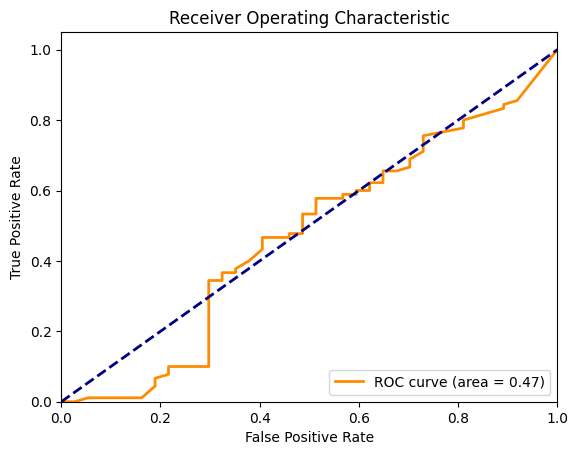

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for modeling
X = df[['sentiment']]  # Predictor
y= df['rating']  # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # probabilities for ROC curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob,pos_label='high')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/Roomba.csv')
df= df.dropna()
# Create the 'rating' column based on 'Stars'
df['rating'] = df['Stars'].apply(lambda x: 'high' if x > 4 else 'low')
# drop data with missing values in the 'Review' column
df = df.dropna(axis=0, subset=['Review'])

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel

In [ ]:

if isinstance(df['Review'].iloc[0], str):
    df['text_preprocessed'] = df['Review'].apply(lambda x: x.split())

# Create a Dictionary and Corpus from the preprocessed text
id2word_preprocessed = corpora.Dictionary(df['text_preprocessed'])
corpus_preprocessed = [id2word_preprocessed.doc2bow(text) for text in df['text_preprocessed']]

# Step 2: Initialize and fit the LDA model
lda_model_preprocessed = LdaModel(corpus=corpus_preprocessed, id2word=id2word_preprocessed, num_topics=10, random_state=42, update_every=1, passes=10, alpha='auto', per_word_topics=True)

# Step 3: Extract Topic Distributions
topic_distributions_preprocessed = [lda_model_preprocessed.get_document_topics(bow) for bow in corpus_preprocessed]

# Normalize topic distributions and ensure each document has distribution over all 10 topics
def normalize_topic_distributions(distributions, num_topics=10):
    normalized = []
    for dist in distributions:
        doc_topics = dict(dist)
        normalized.append([doc_topics.get(i, 0) for i in range(num_topics)])
    return normalized

# Normalize topic distributions
normalized_topics_preprocessed = normalize_topic_distributions(topic_distributions_preprocessed)

# Create DataFrame with topic distributions
topics_df_preprocessed = pd.DataFrame(normalized_topics_preprocessed, columns=[f"Topic{i+1}" for i in range(10)])

# Concatenate original DataFrame with topics DataFrame
df_with_topics_gensim_preprocessed = pd.concat([df, topics_df_preprocessed], axis=1)

# Display the DataFrame with topics
df_with_topics_gensim_preprocessed.head()

,Date,Product,Stars,Title,Review,rating,text_preprocessed,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
0,2/28/15,iRobot Roomba 650 for Pets,5.0,Five Stars,You would not believe how well this works,high,"[You, would, not, believe, how, well, this, wo...",0.0,0.029124,0.0,0.000000,0.938060,0.0,0.0,0.0,0.000000,0.0
1,1/12/15,iRobot Roomba 650 for Pets,4.0,Four Stars,You just walk away and it does the rest,low,"[You, just, walk, away, and, it, does, the, rest]",0.0,0.960713,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2,12/26/13,iRobot Roomba 650 for Pets,5.0,Awesome love it.,You have to Roomba proof your house but once t...,high,"[You, have, to, Roomba, proof, your, house, bu...",0.0,0.937832,0.0,0.000000,0.000000,0.0,0.0,0.0,0.047059,0.0
3,8/4/13,iRobot Roomba 650 for Pets,3.0,Love-hate this vaccuum,"Yes, it's a fascinating, albeit expensive, bit...",low,"[Yes,, it's, a, fascinating,, albeit, expensiv...",0.0,0.255565,0.0,0.740502,0.000000,0.0,0.0,0.0,0.000000,0.0
4,12/22/15,iRobot Roomba 650 for Pets,5.0,This vacuum is fantastic!!,Years ago I bought one of the original Roomba'...,high,"[Years, ago, I, bought, one, of, the, original...",0.0,0.000000,0.0,0.000000,0.997349,0.0,0.0,0.0,0.000000,0.0


In [ ]:
df_with_topics_gensim_preprocessed = df_with_topics_gensim_preprocessed.dropna()

Confusion Matrix:
 [[66 24]
 [30  7]]


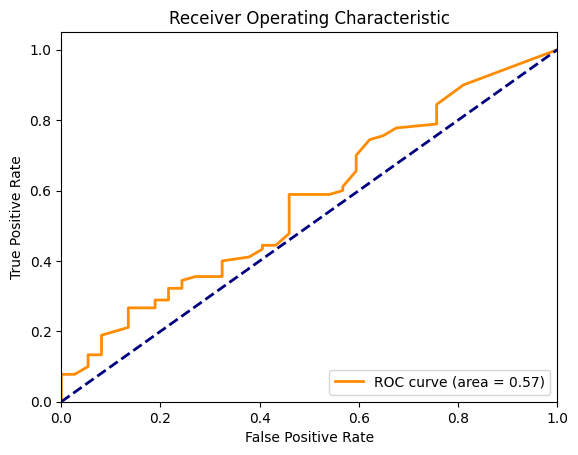

,Feature,Importance
1,Topic2,0.572083
4,Topic5,0.239647
3,Topic4,0.042429
0,Topic1,0.036614
8,Topic9,0.029260
2,Topic3,0.027910
5,Topic6,0.019001
7,Topic8,0.017325
6,Topic7,0.015730


In [ ]:
# Prepare the data for modeling, excluding one topic for independence
X = df_with_topics_gensim_preprocessed[[f"Topic{i+1}" for i in range(9)]]  # Using Topic1 to Topic9
y = df_with_topics_gensim_preprocessed['rating']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate ROC curve and AUC if both classes are present in the test set
if len(np.unique(y_test)) > 1:
    y_prob = rf_classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='high')
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve not plotted. The test set does not contain both classes.")

# Feature importances from the Random Forest model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances

Read the `imdb.csv` file and predict the sentiment based on the review of the movie.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RDGopal/IB9CW0-Text-Analytics/main/Data/imdb.csv')
df= df.dropna()

In [ ]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
9994,"First off, this is the worst movie I've ever s...",negative
9995,"Fun, entertaining movie about WWII German spy ...",positive
9996,Give me a break. How can anyone say that this ...,negative
9997,This movie is a bad movie. But after watching ...,negative


In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply the polarity_scores method to each text entry individually
df['review_sentiment'] = df['review'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Display the first few rows to verify
df[['review_sentiment', 'sentiment']]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,review_sentiment,sentiment
0,-0.9951,positive
1,0.9641,positive
2,0.9605,positive
3,-0.9213,negative
4,0.9744,positive
...,...,...
9994,-0.7160,negative
9995,0.9756,positive
9996,0.9220,negative
9997,-0.9485,negative


Confusion Matrix:
 [[595 365]
 [322 718]]


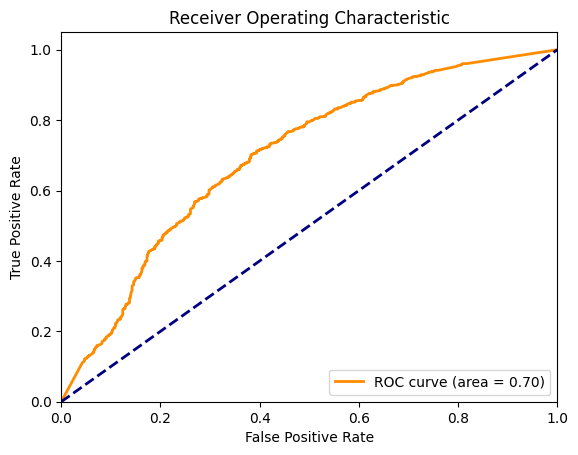

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for modeling
X = df[['review_sentiment']]  # Predictor
y= df['sentiment']  # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # probabilities for ROC curve

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob,pos_label='positive')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel

In [ ]:
if isinstance(df['review'].iloc[0], str):
    df['text_preprocessed'] = df['review'].apply(lambda x: x.split())

# Create a Dictionary and Corpus from the preprocessed text
id2word_preprocessed = corpora.Dictionary(df['text_preprocessed'])
corpus_preprocessed = [id2word_preprocessed.doc2bow(text) for text in df['text_preprocessed']]

# Step 2: Initialize and fit the LDA model
lda_model_preprocessed = LdaModel(corpus=corpus_preprocessed, id2word=id2word_preprocessed, num_topics=10, random_state=42, update_every=1, passes=10, alpha='auto', per_word_topics=True)

# Step 3: Extract Topic Distributions
topic_distributions_preprocessed = [lda_model_preprocessed.get_document_topics(bow) for bow in corpus_preprocessed]

# Normalize topic distributions and ensure each document has distribution over all 10 topics
def normalize_topic_distributions(distributions, num_topics=10):
    normalized = []
    for dist in distributions:
        doc_topics = dict(dist)
        normalized.append([doc_topics.get(i, 0) for i in range(num_topics)])
    return normalized

# Normalize topic distributions
normalized_topics_preprocessed = normalize_topic_distributions(topic_distributions_preprocessed)

# Create DataFrame with topic distributions
topics_df_preprocessed = pd.DataFrame(normalized_topics_preprocessed, columns=[f"Topic{i+1}" for i in range(10)])

# Concatenate original DataFrame with topics DataFrame
df_with_topics_gensim_preprocessed = pd.concat([df, topics_df_preprocessed], axis=1)

# Display the DataFrame with topics
df_with_topics_gensim_preprocessed.head()

,review,sentiment,review_sentiment,text_preprocessed,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
0,One of the other reviewers has mentioned that ...,positive,-0.9951,"[One, of, the, other, reviewers, has, mentione...",0,0.174150,0.0,0.825505,0.0,0,0.0,0.0,0.0,0
1,A wonderful little production. <br /><br />The...,positive,0.9641,"[A, wonderful, little, production., <br, /><br...",0,0.477961,0.0,0.521377,0.0,0,0.0,0.0,0.0,0
2,I thought this was a wonderful way to spend ti...,positive,0.9605,"[I, thought, this, was, a, wonderful, way, to,...",0,0.117862,0.0,0.881509,0.0,0,0.0,0.0,0.0,0
3,Basically there's a family where a little boy ...,negative,-0.9213,"[Basically, there's, a, family, where, a, litt...",0,0.081019,0.0,0.918231,0.0,0,0.0,0.0,0.0,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,0.9744,"[Petter, Mattei's, ""Love, in, the, Time, of, M...",0,0.658904,0.0,0.340650,0.0,0,0.0,0.0,0.0,0


Confusion Matrix:
 [[546 414]
 [465 575]]


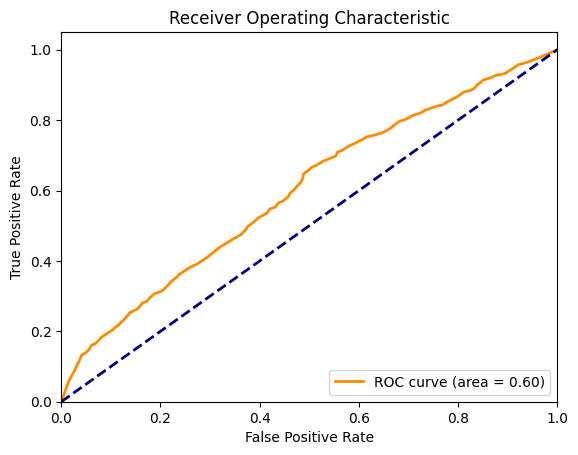

,Feature,Importance
3,Topic4,0.547233
1,Topic2,0.442724
4,Topic5,0.004712
8,Topic9,0.003261
7,Topic8,0.000899
6,Topic7,0.000787
2,Topic3,0.000385
0,Topic1,0.000000
5,Topic6,0.000000


In [ ]:
df_with_topics_gensim_preprocessed = df_with_topics_gensim_preprocessed.dropna()
# Prepare the data for modeling, excluding one topic for independence
X = df_with_topics_gensim_preprocessed[[f"Topic{i+1}" for i in range(9)]]  # Using Topic1 to Topic9
y = df_with_topics_gensim_preprocessed['sentiment']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate ROC curve and AUC if both classes are present in the test set
if len(np.unique(y_test)) > 1:
    y_prob = rf_classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label='positive')
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve not plotted. The test set does not contain both classes.")

# Feature importances from the Random Forest model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances